# the id scheme
Let $n,m$ two positive integers.<br>
${\rm{Public\ Key}} = (A,{\bf b},{\mathcal{S}},{\mathcal{S}'})\in {\mathcal{M}}_{m\times n}({\mathbb{Z}})\times {\mathbb{Z}}^{m}\times {\mathbb{Z}}^{n}\times {\mathbb{Z}}^n$<br>
${\rm{secret\ key}}={\bf x}$, such that $A{\bf x}^T={\bf b}^T,$ and ${\bf x}\in {\mathcal{S}}$
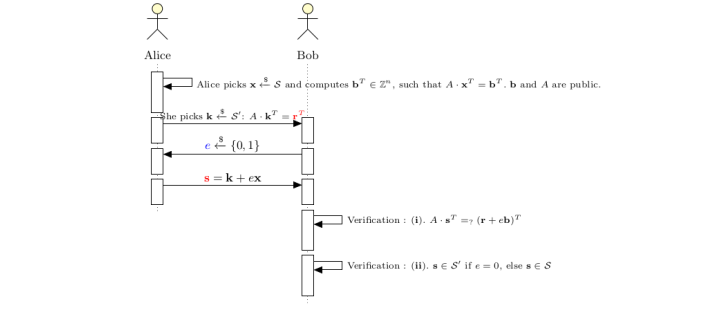

In [1]:
'''
The code is written and tested in Sagemath ver. 9.8
License : GPL v.2
Authors : G. Rizos, K. Draziotis
'''


reset()
def bits(n):
    return floor(log( max ( abs(n), 1) ,2))+1

def domains(L,R):
    '''
    input  : L = [a1,...,ak]
    output : 
    [2^(ai*R-1),2^(ai*R)-1],...,[2^(ak*R-1),2^(ak*R)-1]]
    '''
    
    for x in L:
        if x>1:
            print("ai must be < 1")
            return
    M = []
    l = len(L)
    for i in range(l):
        m = L[i]*R
        if m in ZZ:
            M.append([int(2^(m-1)),int(2^m-1)])
        else:
            if abs(round(m)-m)<1e5:
                m = round(m)
                M.append([int(2^(m-1)),int(2^m-1)])
            else:
                print("ai*R is not integer")
                return 0
    return M

def random_solution(sectors, n):
    '''
    This function is used to compute a random solution x of the system Ax=b where
    x in S. x has dimension n.
    
    Input:
    sectors: is a list of lists [ [a1,a2],[b1,b2],...]
    n      : is a positive integer such that n = 0 mod len(sector)
    
    Output:
    returns a vector (w1,w2,...), where a1<=w1<=a2,....
    '''   
    if int(n)%int(len(sectors)) !=0:
        print("n =",n," must be divisible by :", len(sector))
        return 1,0,0
    rand = lambda n, bounds: [ZZ.random_element(bounds[0], bounds[1] + 1) for _ in range(n)]
    x = []
    for bounds in sectors:
        x = x + rand(n//len(sectors), bounds)
    return vector(x)

def gen_A_and_x(R, n, m, mode, L):
    '''
    R : bits
    n : number of rows
    m : number of equations
    mode: denominator of \frac{R}{mode} that defines the space I_{R/mode}, whose elements generate the matrix A.
    L : is a list that is used to compute domains(L,R)
    output : A, x, b, such that Ax=b
    '''    
    if R%mode!=0:
        return "mode must divide R. function : gen_A_and_x"
    bits = lambda R, mode: (2 ** (R / mode - 1), 2 ** (R / mode) - 1)
    left, right = bits(R, mode) # To generate the matrix A

    # Now, we generate a matrix with (n-1) rows, and random integer elements from the interval [left, right]
    A = matrix([vector([ZZ.random_element(left, right + 1) for _ in range(n)]) for _ in range(m)])
    # Now, we choose a solution with constraints
    sectors = domains(L,R)
    x = random_solution(sectors, n)
    # and the constant vector of the system
    b = (A * x)  
    #print("b=",b)
    return A, x, b

def betai(R,ai,epsilon):
    A=1/(R*ln(2))
    B=ln(2^(ai*R-1)+1)
    C=ln(epsilon * 2^(ai*R+1) + 2) - ln(3)
    return A.n()*B.n(),A.n()*C.n()


In [2]:
R = 36;
n=10;     # 10 columns
m = 4;    # 4 rows
mode = 4; # the elements of matrix A have entris with (R/mode) bits  i.e.  20/4=5 bits
a1 = 1/4;
a2 = 1/2;
L = [a1,a2]; # the solutions have two parts (x1,x2), where x1 is in Z^{5} with entries 20/4=5 bits and x2 with 20/2=10 bits
S = domains(L,R)
epsilon = 1/2.1
u1=betai(R,a1,epsilon)
u2=betai(R,a2,epsilon)
b1,b2=4/20,9/20
print(u1,u2)
print(b1<min(u1),b2<min(u2))
M = [b1,b2]
S_prime = domains(M,R)
A,x,b = gen_A_and_x(R, n, m, mode, L)

(0.222378459699830, 0.204182038145845) (0.472222527967991, 0.454018325793758)
True True


In [3]:
show("A=",A)
print("x :",x)
print("b :",b)
print("S :",S)
print("S':",S_prime)

'A=' [511 434 311 480 350 499 319 324 419 316]
[317 419 298 487 386 368 340 311 458 297]
[322 261 456 266 359 290 371 496 378 423]
[420 436 295 269 436 405 454 382 382 289]

x : (383, 438, 279, 432, 456, 258761, 171177, 133389, 251506, 147140)
b : (379662026, 354573010, 362661273, 372815070)
S : [[256, 511], [131072, 262143]]
S': [[64, 127], [32768, 65535]]


# First Move
Alice choose $k$ from $S'$

In [4]:
def nonce(S_prime):
    k1 = [ZZ.random_element(S_prime[0][0],S_prime[0][1]+1) for _ in range(n/2)]
    k2 = [ZZ.random_element(S_prime[1][0],S_prime[1][1]+1) for _ in range(n/2)]
    k = k1+k2
    return k

In [5]:
k = nonce(S_prime);k
# and sends to Bob
r = A*matrix(k).T
r

[96513721]
[89383972]
[95894609]
[95471264]

# Second Move
Bob chooses a bit

In [6]:
def coin():
    return ZZ.random_element(2)

In [7]:
e = coin();e

0

# third move
Alice responds with ${\bf s}={\bf k}+e{\bf x}$

In [8]:
def respond(k,e,x):
    k = vector(k)
    x = vector(x)
    return k + e*x

In [9]:
s=respond(k,e,x);s

(84, 102, 119, 114, 105, 65370, 36681, 54623, 53735, 37229)

# Verification

In [10]:
def number_of_good_entries_single(list, bound):  # the number of entries in the interval [lower,upper]
        '''
        sage:number_of_good_entries_single([2,10,11,90],[90,100])
             (1,3)
        '''
        C = 0
        inbound = lambda x, low, up: (x <= up and x >= low)
        for i in range(len(list)):
            if inbound(list[i], *bound):
                C = C + 1
        return C, len(list) - C  # number of good and bad entries
    
def verification(A,b,r,transcript,sk,S,S_prime,n):
        #Modified functions for dynamic execution
    
    
    k,e,s=transcript[0],transcript[1],transcript[2]
    #print(k,e,s)
    # first check
    print("first check:",A*matrix(s).T == r + e*matrix(b).T)
    # second check
    lst1=S_prime[0] 
    lst2=S_prime[1]
    lst3=S[0]
    lst4=S[1]
    if e==0:
        if number_of_good_entries_single(s[0:n/2],lst1)[0]==n/2 and number_of_good_entries_single(s[n/2:n],lst2)[0]==n/2:
            print("second check:true","e=",e)
            return "pass[1]"
        else:
            print("second check:false")
            return "fail[1]"
        # check if s \in S'
    else: # i.e if e=1
        #print(number_of_good_entries_single(s[0:n/2],lst3))
        #print(number_of_good_entries_single(s[n/2:n],lst4))
        if number_of_good_entries_single(s[0:n/2],lst3)[0]==n/2 and number_of_good_entries_single(s[n/2:n],lst4)[0]==n/2:
            print("second check:true","e=",e)
            return "pass[2]"
        else:
            print("second check:false")
            return "fail[2]"
        # check if s \in S
        
   

In [11]:
transcript = [vector(k),e,s]
verification(A,b,r,transcript,x,S,S_prime,n)

first check: True
second check:true e= 0


'pass[1]'

# Computation of the length of PK and SK

In [16]:
def length_sig(R,t,n,m,mode,L,M,r,s):
    def bits(x):
        return floor(log(x,2))+1
    print("R=",R)
    print("m,n=",m,n)
    print("S=",L)
    print("S'=",M)
    len_A = n*m*bits(A[0][0])
    len_b = sum(bits(b[i]) for i in range(len(b)))
    len_x = sum([bits(x[i]) for i in range(len(x))])
    print("pk:",len_A+len_b)
    print("sk:",len_x)
    print("sum of pk and sk:",len_A+len_x+len_b, "bits")
    len_r = sum([bits(r.list()[i]) for i in range(len(r.list()))])
    print("r_len:", len_r )
    len_s = sum([bits(s[i]) for i in range(len(s))])
    print("s_len:", sum([bits(s[i]) for i in range(len(s))]) )
    print("|R|+|S|:",t*(len_r+len_s))

In [17]:
length_sig(R,80,n,m,mode,L,M,r,s)

R= 36
m,n= 4 10
S= [1/4, 1/2]
S'= [1/5, 9/20]
pk: 476
sk: 135
sum of pk and sk: 611 bits
r_len: 108
s_len: 115
|R|+|S|: 17840


# All the code in one cell

In [14]:
def probability(R,a1,a2,b1,b2):
    A1 = 3*2^(b1*R-1)-1
    B1 = 2^(a1*R)
    A2 = 3*2^(b2*R-1)-1
    B2 = 2^(a2*R)
    print( (A1/B1).n(),(A2/B2).n())
    
def execution(R,n,m,mode,L,M,count,Print):
    S = domains(L,R)
    S_prime = domains(M,R)
    # pk and sk
    print("[+] generate public and secret key")
    A,x,b = gen_A_and_x(R, n, m, mode, L)
    for j in range(count):
        print('[+]',j+1)
        # 1: Alice
        if Print=='1':
            print("[+] Step one, Alice picks the nonce k and sends A*k")
        k = nonce(S_prime)
        r = A*matrix(k).T
        # 2: Bob
        if Print=='1':
            print("[+] Second Step, Bob pick a random bit e")
        e = coin()
        #print("e=",e)
        # 3: Alice
        if Print=='1':
            print("[+] Third Step, Alice resdponds with k+ex")
        s =respond(k,e,x)
        transcript = [vector(k),e,s]
        #print("transcript (k,e,s) : ")
        #print(vector(k),e,s)
        #print(A*matrix(s).T==r + e*matrix(b).T)
        verification(A,b,r,transcript,x,S,S_prime,n)
        if count==1:
            return r,s

In [23]:

# find b1,b2 such that b1*R,b2*R are integers
# and bi<ai, with bi~ai
# so bi = ci/R (ci<ai*R)
a1 = 1/4;
a2 = 1/2;
L = [a1,a2]
R = 192
print(R)
print(a1*R,a2*R)
c1,c2=8,17
c1,c2=R/8,R/4
b1 = c1/R;b2=c2/R
print(a1.n(),a2.n())
print(b1.n(),b2.n())
print(b1*R,b2*R)
#R = 36;
n=42;     # 10 columns
m = 4;    # 4 rows
mode = 8; # the elements of matrix A has entriw with R/mode bits  i.e.  20/4=5 bits
#b1,b2=4/20,9/20
#print(b1<u1,b2<u2)
M = [b1,b2]

192
48 96
0.250000000000000 0.500000000000000
0.125000000000000 0.250000000000000
24 48


In [24]:
probability(R,a1,a2,b1,b2)

8.94069636103723e-8 5.32907051820074e-15


In [25]:
print("R=",R)
count=1
r,s=execution(R,n,m,mode,L,M,count,'0')

R= 192
[+] generate public and secret key
[+] 1
first check: True
second check:true e= 1


In [26]:
length_sig(R,80,n,m,mode,L,M,r,s)

R= 192
m,n= 4 42
S [1/4, 1/2]
S' [1/8, 1/4]
pk: 1628
sk: 135
sum: 1763
r_len: 304
s_len: 3024
|R|+|S|: 266240
